In [1]:
import sys, os
old = sys.stdout
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = old

In [17]:
import scipy.io as sio
import statsmodels.tsa.stattools as stm
import numpy as np
from statsmodels.tsa.ar_model import AR

In [18]:
from matplotlib import pyplot
import math
import time

In [19]:
filename = []
directory = '/Users/apple/Desktop/eeglab14_1_2b/ICA_Data/'
for file in os.listdir(directory):
    if file.endswith(".mat"):
        filename.append(file)
filename.sort()
filename = filename[31::]
print(filename)
temp_trial = sio.loadmat(filepath)['data']

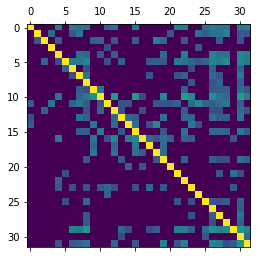

KeyboardInterrupt: 

In [20]:
for eegdata in filename:
    filepath = directory + eegdata
    mat_contents = sio.loadmat(filepath)
    ica = mat_contents['data']
    hz = 128
    #a 3 second pre-trial baseline removed
    trial = ica.shape[2]
    print("{}: {}".format("Total number of trials is", trial))
    channel = temp_trial.shape[0]
    print("{}: {}".format("Total number of channels in each trial is", channel))
    timepoint = temp_trial.shape[1]
    print("{}: {}".format("Total number of time points in per channel per trial is", timepoint))
    for t in range(trial):
        hz = 128
        #a 3 second pre-trial baseline removed
        temp_trial = ica[:,:,t]
        temp_trial = temp_trial[:,hz*3:]
        MGCM = np.zeros((channel,channel))
        for k in range(60):
            enablePrint()
            print(k)
            blockPrint()
            current_trial = temp_trial[:, k*hz:(k+1)*hz]
            for i in range(channel):
                for j in range(channel):
                    if i == j:
                        print("{} -> {}:{}".format(k,i,j))
                        MGCM[i,j] = 1
                    blockPrint()
                    x = np.vstack((np.asarray(current_trial[i,:]), np.asarray(current_trial[j,:]))).T
                    maxlag = 3
                    result = stm.grangercausalitytests(x, maxlag, addconst = True, verbose = True)
                    optimal_lag = -1
                    F_test = -1.0
                    for key in result.keys():
                        _F_test_ = result[key][0]['params_ftest'][0]
                        if _F_test_ > F_test:
                            F_test = _F_test_
                            optimal_lag = key
                    if (result[optimal_lag][0]['params_ftest'][1] < 0.03):
                        MGCM[i,j] = math.log(result[optimal_lag][0]['params_ftest'][0])
                    else:
                        MGCM[i,j] = 0
            enablePrint()
            diag = np.max(MGCM)
            for i in range(channel):
                for j in range(channel):
                    if i == j:
                        MGCM[i,j] = 1
                    else:
                        MGCM[i,j] = MGCM[i,j]/diag
            enablePrint()
            pyplot.matshow(MGCM)
            pyplot.show()
            np.append(result,MGCM)
            eegdata = os.path.splitext(eegdata)[0]
            imgname = "img/{0}_{1}_{2}.png".format(eegdata, str(t).zfill(2), str(k).zfill(2))
            pyplot.imsave(imgname, MGCM)